# Main

This is the main file of the DigitalTwinBridge project by Isabelle Pumford. Here the functions from the other files will be called so that an easy pipeline can be created for analyzing different years/stations

In [3]:
from ipynb.fs.defs.Lanes import trucks_per_lane, weight_per_lane
from ipynb.fs.defs.WIMConversion import load_table_from_struct, df_cleaning, to_pickle
from ipynb.fs.defs.YearlyTrends import yearly_daily_vehicle, yearly_weight, yearly_platoon
from ipynb.fs.defs.PlatoonFinding import one_lane_platoon, truck_type_filter, truck_type_graph, violin_weight_length, platoon_log_hist

C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
stations = ['Ceneri']
start_year = 2011
end_year = 2019
platoon_headway = 2

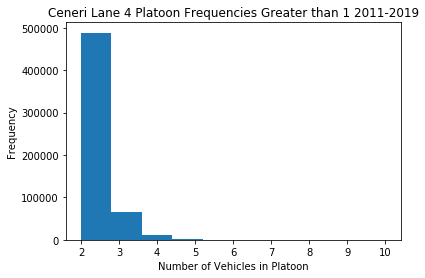

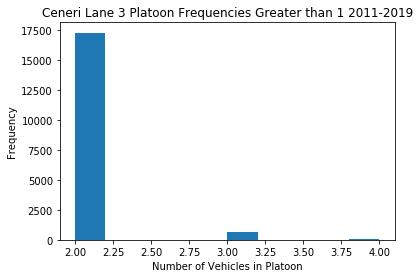

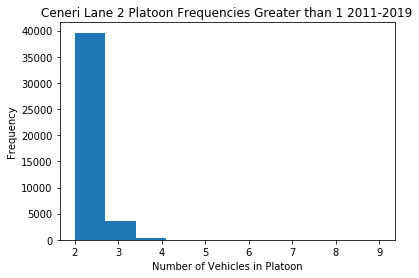

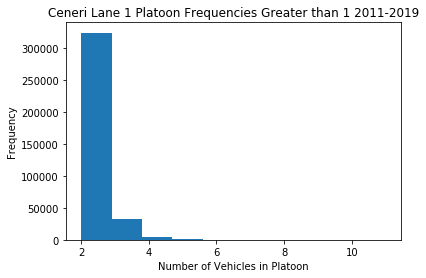

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [13]:
df_test = one_lane_platoon(station, start_year, end_year, False, platoon_headway)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style('darkgrid')
plt.rc('figure',figsize=(12,8))
plt.rc('font',size=13)
sns.set(rc={'figure.figsize':(11.7,8.27)})

df = pd.read_pickle('{}Data/{}_{}_datetime.pkl'.format(stations[0], start_year, end_year))    

lanes = df.FS.unique()

#For each lane in lanes, find the individual platoon histogram and most common platoon combinations
df_platoon = []
for lane in lanes:
    df_lane = df.loc[df['FS'] == lane]

    df_lane = df_lane.set_index('Date')
    df_lane = df_lane.sort_index()
    df_lane['HEAD_T'] =(df_lane.index.to_series().shift(-1) - df_lane.index.to_series()).dt.total_seconds() #Truck headway

    threshold_selector = df_lane.HEAD_T > platoon_headway #defines a headway of three seconds as the threshold
    groups = threshold_selector.cumsum()
    df_lane['Start']  = df_lane.index.to_series()
    df_lane['End'] = df_lane.index.to_series()
    df_lane_platoon = df_lane.groupby(groups).agg({'Start':min, 'End':max, 'CLASS': lambda x: x.tolist(), 'GW_TOT': lambda x: x.tolist(), 'LENTH': lambda x: x.tolist(), })
    df_lane_platoon['Platoon'] = (df_lane_platoon.CLASS.str.len() > 1)
    df_lane_platoon['Length'] = df_lane_platoon.CLASS.str.len()
    df_plot = df_lane_platoon[df_lane_platoon.Length > 1]
    ax = df_plot['Length'].plot.hist(bins=10, title= "{} Lane {} Platoon Frequencies Greater than 1 {}-{}".format(stations[0], lane, start_year, end_year)) 
    ax.set_xlabel('Number of Vehicles in Platoon')
    plt.show()
    if mode:
        #Display the combinations of platoons that are the most common for 2, 3 and 4 length
        print(df_lane_platoon[df_lane_platoon.Length == 2].CLASS.apply(tuple).value_counts().head().to_string())
        print(df_lane_platoon[df_lane_platoon.Length == 3].CLASS.apply(tuple).value_counts().head().to_string())
        print(df_lane_platoon[df_lane_platoon.Length == 4].CLASS.apply(tuple).value_counts().head().to_string())
    df_lane_platoon['Lane'] = int(lane)
    df_platoon.append(df_lane_platoon)

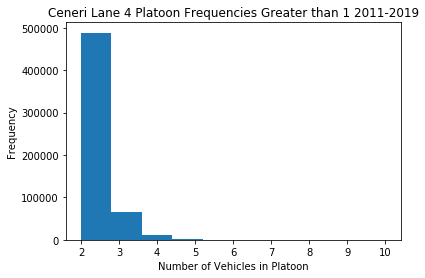

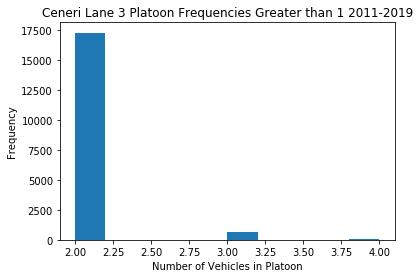

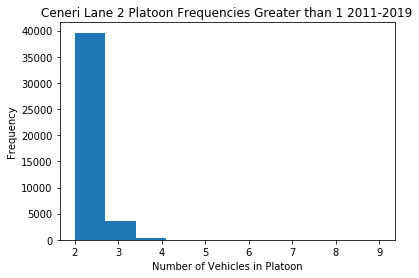

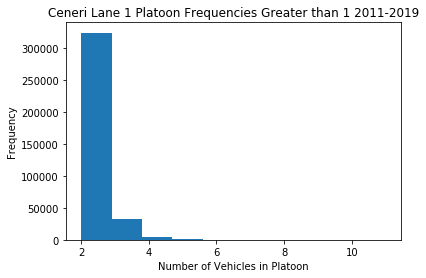

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [10]:
for station in stations:
    
    #to_pickle(station, start_year, end_year)
    
    #trucks_per_lane(station, start_year, end_year)
    #weight_per_lane(station, start_year, end_year)
    
    #Find the platoons
    one_lane_platoon(station, start_year, end_year, False, platoon_headway)
    #overall platoon histogram
    platoon_log_hist(station, start_year, end_year, platoon_headway)
    #truck type breakdown
    #truck_type_graph(station, start_year, end_year, False)
    
    yearly_daily_vehicle(station, start_year, end_year, platoon_headway)
    yearly_weight(station, start_year, end_year, platoon_headway, True)
    yearly_platoon(station, start_year, end_year, platoon_headway)
    
    #Seasonality
    seasonality = 'Daily'
    platoon_seasonality(station, start_year, end_year, platoon_headway, seasonality, False, False)
    weight_seasonality(station, start_year, end_year, platoon_headway, seasonality)
    count_seasonality(station, start_year, end_year, platoon_headway, seasonality, False)